The dataset contains 1250 headlines from a variety of news publications. Each is given a rating between 0 and 100 for six emotion categories. 

Since ninety eight percent of the dataset has at least two emotions with non-zero ratings, it makes sense to treat this task as a multilabel classification probelm. The model should be able to make a prediction (present or not present) for each emotion label. 

In this notebook, I use the skmultilearn package's Chain Classifier with a Support Vector Classifier and a Recurrent Neural Network to make predictions and compare the results.

The best performing model for this task was ...


In [1]:
# basics
import pandas as pd
import numpy as np
import itertools

# vectorizer, classifiers, and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, confusion_matrix, jaccard_score, hamming_loss, log_loss
from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.multiclass import OneVsRestClassifier

# rnn
import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# custom functions, class to import and process data
from get_labeled_dfs import *
from process_text import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# use custom function to get the corpus df and labels 
corpus_df, emotion_df, valence_df = get_labeled_dfs()


In [3]:
# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)


In [4]:
# after processing, the text in the corpus df is all lower case, free of punctuation (except emotion-relevant exclamation points and question marks), 
# numbers, and special characters, and lemmatized
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,hussein ally hang iraqi official
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [5]:
# The emotion df contains ratings for each emotion, the max rating, and label columns 
# for each emotion with a 1 indicating that the emotion is present (it has a non-zero 
# rating) or a 0 indicating that it is not.  
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


## Prepare Multilabel Classification Evaluation

I've compiled my evaluation metrics in two functions. One is for evaluating how a model performed with respect to each individual emotion label. The other is a set of summary scores useful for comparing a model's overall performace with other models.

### Evaluating preformance on individual emotion labels

I use confusion matrices to display predicted labels vs. actual labels.

To compare performace on individual labels, I use accuracy, precision, recall, and f1 scores.

* Accuracy score tells us the ratio of correct predictions to total predictions 

* Precision score tells us the ratio of correct predictions to total predictions of the target class 

* Recall score tells us the ratio of correct predictions to the total true cases of the taget class

* F1 is a weighted average of precision and recall



In [6]:
def label_confusion_matrices(lst, df, RNN=False):
    
    '''A function that creates confusion matrices and calculates accuracy, precision, 
    recall, and f1 for each individual label'''
    
    plt.figure(figsize=(10,15))
    subplot_num = 1

    for i in lst:
        
        if RNN==False:
        
            tp = len(df.loc[(df['pred_' + i]==1) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]==1) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]==0) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]==0) & (df[i]==0)])
        
        else:
            
            tp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==0)])
        
        
        plt.subplot(3,2,subplot_num)
        sns.heatmap([[tp, fp], [tn, fn]], square=True, annot=True, fmt='g', yticklabels=[i, 'not ' + i], xticklabels=[i, 'not ' + i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(i.capitalize() + ' Confusion Matrix')
        subplot_num+=1
        
        accuracy = tp/(fp + tn + tp)
        precision = tp/(fp + tp)
        recall = tp/(tp + fn)
        f1 = 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn))))
        
        print(i + " accuracy:", accuracy)
        print(i + " precision:", precision)
        print(i + " recall", recall)
        print(i + " f1", 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn)))))
        print('\n')

        

To evaluate a model's performance on all labels, I compare jaccard similarity, hamming loss, and f1 macro scores.

* Jaccard Similarity is the ratio of correct labels to total predictions.

* Hamming Loss is the ratio of incorrect labels to total predictions. 

* F1 Macro is an mean of f1 scores (see above) for all labels.

Note that Jaccard Similarity and Hamming loss both count the correct or incorrect labels for each individual label and add them together. I use these metrics rather than ones requiring a perfect match across all labels because I'm interesting in knowing whether a model can predict subsets of the correct labels at a higher rate than others. In order to do so, I need metrics that do not treat a prediction that gets five out of six labels correct the same as one that gets zero out of six correct.


In [7]:
def suite_of_scores(y_true, y_pred):
    
    '''A function that calculates jaccard similarity, hamming loss, f1 macro, 
    and log loss to assess the model's overall performance'''
    
    jaccard_score_samples = jaccard_score(y_true, y_pred, average='samples')
    hamming_loss_score = hamming_loss(y_true, y_pred)
    f1_macro_score = f1_score(y_true, y_pred, average='macro')
    
    print('jaccard score average:', round(jaccard_score_samples, 3))
    print('hamming loss:', round(hamming_loss_score, 3))
    print('f1 macro:', round(f1_macro_score, 3))
    

## TF-IDF

The data needs to be transformed into a numeric format before it can be used to train a model. 

One option is to use a [count vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). By this method, each word in the vocabulary is a column and each sentence is a row. The sentence is represented by a count for each word that is present. All other words have zeros.

As an example, I'll use the opening lines of Dickens's *Tale of Two Cities*: "It was the best of times, it was the worst of times" and "It was the age of wisdom, it was the age of foolishness"

| it | was | the | best | of | times | worst | age | wisdom | foolishness |  
|----|-----|-----|------|----|-------|-------|-----|--------|-------------|
|2   |2    |2    |1     |2   |2      |1      |0    |0       |0            |
|2   |2    |2    |0     |2   |1      |1      |2    |1       |1            |



Another option is to use term frequency - inverse document frequency (TF-IDF). TF-IDF is a representation of how import a word is in distinguishing a document from other documents in the corpus. The higher the score, the more significant the word.

It's calculated by multiplying term frequency by inverse document frequency.

* Term Frequency
(times the word appears in the document/number of words in the document)

* Inverse Document Frequency
log(number of documents in the corpus/number of times the word appears in a document in the corpus)

Here's how it looks on the whole document example:

| it | was | the | best | of | times | worst | 
|----|-----|-----|------|----|-------|-------|
|-.23|-.23 |-.23 |.12   |0   |0      |0      |
|-.23|-.23 |-.23 |0     |0   |0      |.12    |


In [124]:
# first split the data into separate training and testing sets
X_train, X_test, y_train, y_test = train_test_split(corpus_df['text'], emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], random_state=3)

# use TfidVectorizer to create an array of TF-IDF scores for each word in the corpus
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)


In [95]:
from sklearn.decomposition import PCA

pca = PCA(n_components=750, random_state=10)
tf_idf_X_train = pca.fit_transform(tf_idf_X_train.toarray())
tf_idf_X_test = pca.transform(tf_idf_X_test.toarray())

## One Versus Rest Model

An important consideration in choosing a multilabel prediction model is whether the labels are independent or correlated. There is some moderate correlation between the labels in my dataset.

*Insert pic*

For comparison, I tested methods that treats labels as independent and methods that allows for label correlations. In this notebook, I include:

* One Versus Rest Classifier

A One Versus Rest classifier trains a separate model for each label in the dataset. Each model's predictions are independent of the other models' predictions.

For this model, I used a logistic regression classifier.

* Correlated: Chain Classifier

A Chain Classifier trains a model for each label in the dataset, but each model's predictions are transferred to the next model, so the probabistic relationships between labels are taken into account.

For this model, I used a linear support vector classifier.


In [96]:
lr = LogisticRegression(C=1e10, class_weight='balanced')

ovr = OneVsRestClassifier(lr)

ovr.fit(tf_idf_X_train, y_train)
ovr_train_preds = ovr.predict(tf_idf_X_train)
ovr_test_preds = ovr.predict(tf_idf_X_test)

In [97]:
ovr_preds_df = pd.DataFrame(ovr_test_preds, columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
ovr_preds_df = pd.concat([ovr_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.4981949458483754
anger_label precision: 0.7840909090909091
anger_label recall 0.7931034482758621
anger_label f1 0.7885714285714285


disgust_label accuracy: 0.3372093023255814
disgust_label precision: 0.635036496350365
disgust_label recall 0.6126760563380281
disgust_label f1 0.6236559139784946


fear_label accuracy: 0.6453900709219859
fear_label precision: 0.8053097345132744
fear_label recall 0.8544600938967136
fear_label f1 0.8291571753986333


joy_label accuracy: 0.5419847328244275
joy_label precision: 0.7282051282051282
joy_label recall 0.7357512953367875
joy_label f1 0.7319587628865978


sadness_label accuracy: 0.6785714285714286
sadness_label precision: 0.8016877637130801
sadness_label recall 0.852017937219731
sadness_label f1 0.8260869565217391


surprise_label accuracy: 0.8896551724137931
surprise_label precision: 0.9181494661921709
surprise_label recall 0.9181494661921709
surprise_label f1 0.9181494661921709




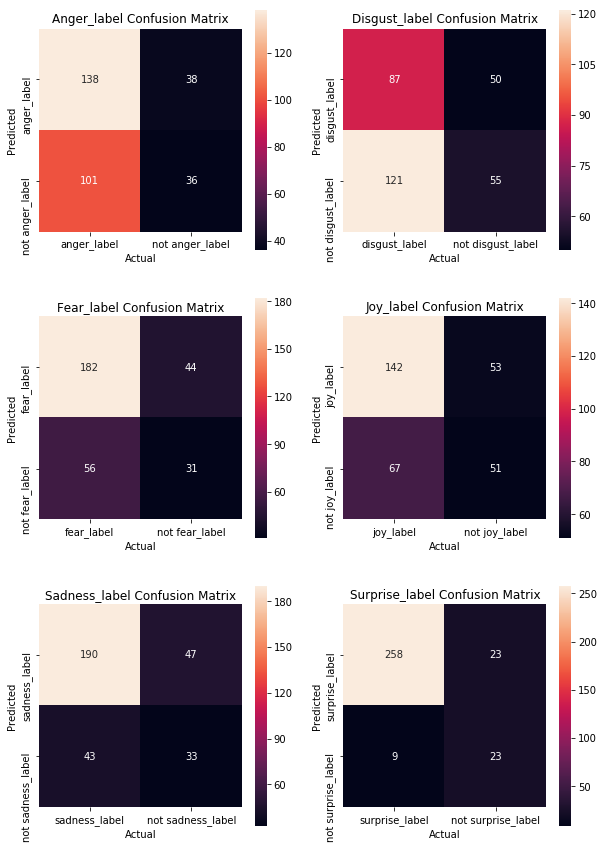

In [98]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], ovr_preds_df)


In [101]:
suite_of_scores(y_test, ovr_test_preds)


jaccard score average: 0.682
hamming loss: 0.258
f1 macro: 0.786


## Classifier Chain

In [102]:
svc = LinearSVC(class_weight='balanced')

perms = list(itertools.permutations([0,1,2,3,4,5]))

chains = [ClassifierChain(svc, order=perms[i]) for i in range(720)]

results_jaccard = []
preds = []
for chain in chains:
    chain.fit(tf_idf_X_train, y_train)
    test_preds = chain.predict(tf_idf_X_test)
    preds.append(test_preds)
    results_jaccard.append(jaccard_score(y_test, test_preds, average='samples'))


In [103]:
cc_test_preds = preds[results_jaccard.index(max(results_jaccard))]
max(results_jaccard)

0.6905750798722045

In [104]:
cc_preds_df = pd.DataFrame(cc_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
cc_preds_df = pd.concat([cc_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.4981949458483754
anger_label precision: 0.8117647058823529
anger_label recall 0.7931034482758621
anger_label f1 0.8023255813953488


disgust_label accuracy: 0.3643122676579926
disgust_label precision: 0.6577181208053692
disgust_label recall 0.6901408450704225
disgust_label f1 0.6735395189003436


fear_label accuracy: 0.6168582375478927
fear_label precision: 0.8518518518518519
fear_label recall 0.755868544600939
fear_label f1 0.8009950248756219


joy_label accuracy: 0.5366795366795367
joy_label precision: 0.7679558011049724
joy_label recall 0.7202072538860104
joy_label f1 0.7433155080213903


sadness_label accuracy: 0.6511627906976745
sadness_label precision: 0.865979381443299
sadness_label recall 0.7533632286995515
sadness_label f1 0.8057553956834532


surprise_label accuracy: 0.887719298245614
surprise_label precision: 0.9233576642335767
surprise_label recall 0.900355871886121
surprise_label f1 0.9117117117117117




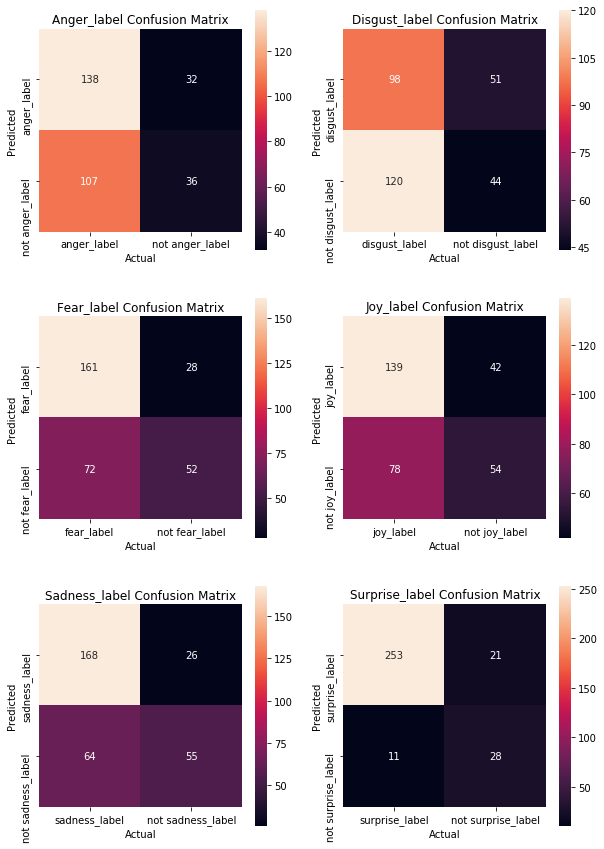

In [105]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], cc_preds_df)



In [21]:
suite_of_scores(y_test, cc_test_preds.toarray())


jaccard score average: 0.703
hamming loss: 0.238
f1 macro: 0.8


In [33]:
new = pd.DataFrame({"text":['meuller on russian election interference theyre doing it as we sit here', 
                                             'justice ginsburg i am very much alive',
                                             'photo of mother pleading with mexican soldier draws attention to migrant patrol',
                                             'how a perfect storm cut off water from this colorado town',
                                             'a requiem for audiogalaxy the digital wild wests best outlaw store',
                                             'rapper meek mill is granted retrial after years long legal fight',
                                             'how to help your anxious partner and yourself',
                                             'travelling together 7 tips to help keep the peace']})
processor = Process_Text_Data()
processor.transform(new)
tf_idf_new = vectorizer.transform(new['text'])

best_chain = chains[results_jaccard.index(max(results_jaccard))]
best_chain.fit(tf_idf_X_train, y_train)
best_chain.predict(tf_idf_new).toarray()

array([[0., 0., 1., 1., 0., 1.],
       [0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1.],
       [1., 0., 1., 0., 1., 1.],
       [0., 0., 0., 1., 0., 1.],
       [1., 0., 1., 1., 1., 1.],
       [1., 0., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1.]])

## RNN for Multilabel Classification

In [76]:
# use custom function to get the corpus df and labels 
corpus_df_RNN, _, _ = get_labeled_dfs()

# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df_RNN, RNN=True)


In [77]:
# create a set of unique words in the corpus
vocab = set()
for headline in corpus_df_RNN['text']:
    for word in headline.split():
        vocab.add(word)

# get vectors from the pretrained vocab and create a dictionary with the words from the set as keys
glove_embeddings = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for i in f:
        key_vec = i.split()
        word = key_vec[0].decode('utf-8')
        if word in vocab:
            glove_embeddings[word] = np.array(key_vec[1:], dtype=np.float32)
            

In [78]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(corpus_df_RNN['text']))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(corpus_df_RNN['text'])

# add zeros to the front of each sequence as necessary to make them all the same length
padded_X = sequence.pad_sequences(sequences, maxlen=15, padding='post')


In [79]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in glove_embeddings.keys():
        embedding_matrix[ind + 1, :] = glove_embeddings[word]
        

In [80]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], test_size=0.25, random_state=10)

# labels multihot encoded
y_train_multihot = y_train.values
y_test_multihot = y_test.values


In [81]:
model = Sequential()

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)]

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=15, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop(lr=.002, decay=.00001),
              metrics=['accuracy'])


history = model.fit(X_train, 
                    y_train_multihot,
                    epochs=30,
                    batch_size=100,
                    callbacks=callbacks,
                    class_weight=[{0: 8, 1: 1}, {0: 10, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}],
                    validation_data=(X_test, y_test_multihot))

W0725 15:19:04.764043 4323595712 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 15:19:04.815089 4323595712 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 15:19:04.834562 4323595712 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 15:19:04.859616 4323595712 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0725 15:19:04.860494 4323595712 deprecation_wrapper

Train on 937 samples, validate on 313 samples
Epoch 1/30
937/937 [==============================] - 3s 3ms/step - loss: 0.6808 - acc: 0.6128 - val_loss: 0.6514 - val_acc: 0.6134
Epoch 2/30
937/937 [==============================] - 0s 470us/step - loss: 0.5222 - acc: 0.7455 - val_loss: 0.6322 - val_acc: 0.6794
Epoch 3/30
937/937 [==============================] - 0s 508us/step - loss: 0.4453 - acc: 0.8054 - val_loss: 0.5944 - val_acc: 0.7183
Epoch 4/30
937/937 [==============================] - 1s 586us/step - loss: 0.3912 - acc: 0.8383 - val_loss: 0.6178 - val_acc: 0.7162
Epoch 5/30
937/937 [==============================] - 1s 535us/step - loss: 0.3413 - acc: 0.8741 - val_loss: 0.6452 - val_acc: 0.7327
Epoch 6/30
937/937 [==============================] - 0s 502us/step - loss: 0.3017 - acc: 0.8993 - val_loss: 0.5702 - val_acc: 0.7471
Epoch 7/30
937/937 [==============================] - 0s 494us/step - loss: 0.2797 - acc: 0.9105 - val_loss: 0.5532 - val_acc: 0.7551
Epoch 8/30
937/937

313/313 [==============================] - 0s 292us/step


[0.5492900748031969, 0.7555910615494457]

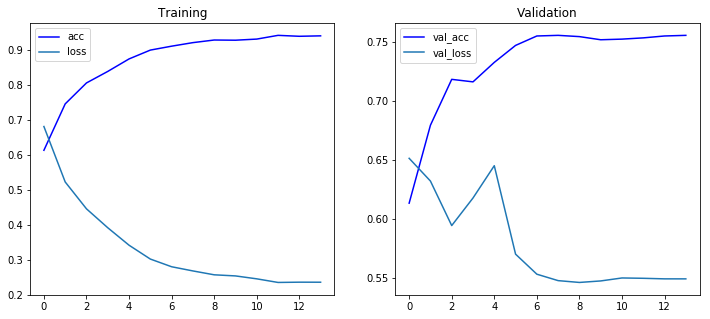

In [82]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')
plt.title("Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.title("Validation")
plt.legend()

model.evaluate(X_test, y_test_multihot)


In [83]:
# model.save('RNN_multiclass_emotion.h5')

RNN_preds = model.predict_on_batch(X_test)

RNN_preds_df = pd.DataFrame({"pred_anger":RNN_preds[:,0], "pred_disgust":RNN_preds[:,1], "pred_fear":RNN_preds[:,2], "pred_joy":RNN_preds[:,3], "pred_sadness":RNN_preds[:,4], "pred_surprise":RNN_preds[:,5], "anger":y_test_multihot[:,0], "disgust":y_test_multihot[:,1], "fear": y_test_multihot[:,2], "joy": y_test_multihot[:,3], "sadness": y_test_multihot[:,4], "surprise": y_test_multihot[:,5]})


anger accuracy: 0.43478260869565216
anger precision: 0.7894736842105263
anger recall 0.7643312101910829
anger f1 0.7766990291262136


disgust accuracy: 0.3118279569892473
disgust precision: 0.6641221374045801
disgust recall 0.71900826446281
disgust f1 0.6904761904761906


fear accuracy: 0.5714285714285714
fear precision: 0.8
fear recall 0.8290155440414507
fear f1 0.8142493638676844


joy accuracy: 0.5384615384615384
joy precision: 0.751412429378531
joy recall 0.6683417085427136
joy f1 0.7074468085106383


sadness accuracy: 0.6245487364620939
sadness precision: 0.8046511627906977
sadness recall 0.8277511961722488
sadness f1 0.8160377358490567


surprise accuracy: 0.8788927335640139
surprise precision: 0.9039145907473309
surprise recall 0.9136690647482014
surprise f1 0.9087656529516993




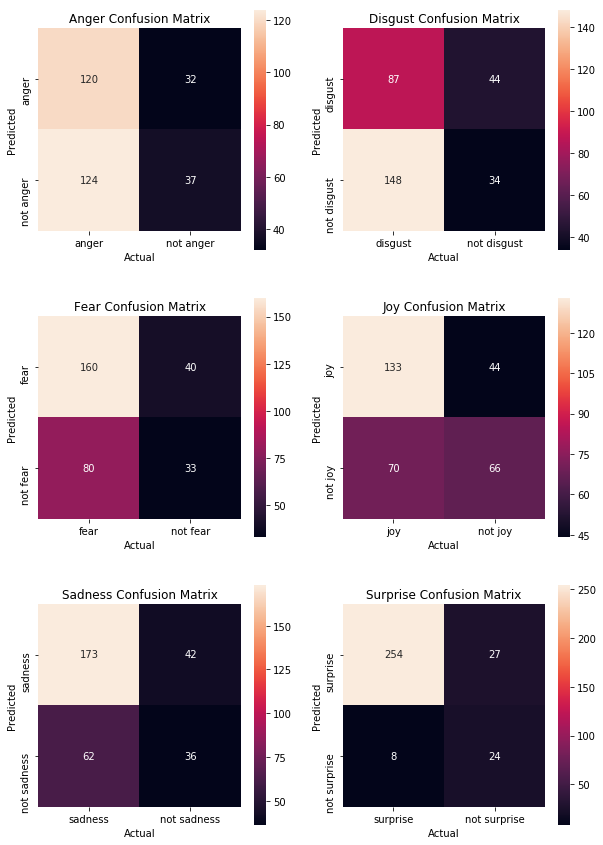

In [84]:
label_confusion_matrices(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'], RNN_preds_df, RNN=True)

In [85]:
suite_of_scores(y_test, RNN_preds>.5)


jaccard score average: 0.691
hamming loss: 0.244
f1 macro: 0.786


## Predict something new

In [86]:
new_sequence = tokenizer.texts_to_sequences(['what a great story about happy people having fun !', 'unbelievable news about that sports team that lost tragically'])
padded_new = sequence.pad_sequences(new_sequence, maxlen=15, padding='post')

model.predict(padded_new)>.5

array([[False, False, False,  True,  True, False],
       [False, False,  True, False,  True,  True]])

In [87]:
# NPR
new_sequence = tokenizer.texts_to_sequences(['meuller on russian election interference theyre doing it as we sit here', 
                                             'justice ginsburg i am very much alive',
                                             'photo of mother pleading with mexican soldier draws attention to migrant patrol',
                                             'how a perfect storm cut off water from this colorado town',
                                             'a requiem for audiogalaxy the digital wild wests best outlaw store',
                                             'rapper meek mill is granted retrial after years long legal fight',
                                             'how to help your anxious partner and yourself',
                                             'travelling together 7 tips to help keep the peace'])
padded_new = sequence.pad_sequences(new_sequence, maxlen=15, padding='post')

In [88]:
model.predict(padded_new)>.5

array([[False,  True,  True, False,  True,  True],
       [False, False,  True, False,  True,  True],
       [ True,  True,  True, False,  True,  True],
       [ True, False,  True,  True,  True,  True],
       [False, False, False,  True, False,  True],
       [False, False,  True, False,  True,  True],
       [False, False, False,  True,  True,  True],
       [False, False,  True,  True, False,  True]])